# GENERACIÓN DE MOVIMIENTOS

In [1]:
import os as os

In [2]:
import tensorflow as tf
import tensorflow.keras as keras

In [3]:
# Módulos necesarios. Asegurarse de poder importarlos.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import sys
from six.moves import cPickle as pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import csv
from pylab import rcParams
from scipy import stats
from sklearn import metrics
import seaborn as sns
from sklearn import preprocessing
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [4]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
tf.__version__

/usr/bin/python
3.6.8 (default, Aug 20 2019, 17:12:48) 
[GCC 8.3.0]
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


'1.14.0'

In [5]:
keras.__version__

'2.2.4-tf'

In [6]:
global activities
activities =  [19]
global subjects
subjects = [1,2,3,5,8,9,10,11,13,14,16,17]
subjects_train = [1,3,5,8,9,11,13,14,17]
subjects_test = [2,10,16]

In [7]:
# Ruta raíz
PATH = '../data_augment/'

quaturls = !ls -1 "{PATH}"

global activities
activities =  [19]
subjects = [1,2,3,8,10,13,14,15,16,17]

quat_corr = []
for filename in quaturls:
    for activity in activities:
        if(int(filename[-6:-4])==activity):
            quat_corr.append(filename)

quat_def = []

i=0
for filename in quat_corr:
    for subject in subjects:
        if(int(quat_corr[i][8:10])==subject):
            quat_def.append(filename)
    i+=1

quaturls = quat_def

del quat_corr, quat_def

n = len(quaturls)

tr_urls = quaturls

print('Total files: ' + str(len(quaturls)))
print('Train files: ' + str(len(tr_urls)))

tr_fullpath = [os.path.join(PATH,s) for s in tr_urls]
print('TRAINING: ')
print(str(tr_fullpath[:10]) + ' ...')

Total files: 216
Train files: 216
TRAINING: 
['../data_augment/subject_01_AUGMENT_deg_-105_act_19.csv', '../data_augment/subject_01_AUGMENT_deg_-120_act_19.csv', '../data_augment/subject_01_AUGMENT_deg_-135_act_19.csv', '../data_augment/subject_01_AUGMENT_deg_-150_act_19.csv', '../data_augment/subject_01_AUGMENT_deg_-15_act_19.csv', '../data_augment/subject_01_AUGMENT_deg_-165_act_19.csv', '../data_augment/subject_01_AUGMENT_deg_-30_act_19.csv', '../data_augment/subject_01_AUGMENT_deg_-45_act_19.csv', '../data_augment/subject_01_AUGMENT_deg_-60_act_19.csv', '../data_augment/subject_01_AUGMENT_deg_-75_act_19.csv'] ...


In [8]:
global ind
ind=3600

### Generación del dataset

In [9]:
def sliding_window(df, n_time_steps, step, segments, labels, label, dim, train, n_channels):
    quat0 = df.iloc[:, 1:5][df['QUAT']=='quat0'].reset_index() # si no incluimos el reset_index(), al concatenarlos después
    quat1 = df.iloc[:, 1:5][df['QUAT']=='quat1'].reset_index() # aparecerá un dataframe de igual nº de filas que df, pero con
    quat2 = df.iloc[:, 1:5][df['QUAT']=='quat2'].reset_index() # NaN en las posiciones que no tienen número de cada dataframe quat,
    quat3 = df.iloc[:, 1:5][df['QUAT']=='quat3'].reset_index() # es decir, mantiene los índices de df.
    quat4 = df.iloc[:, 1:5][df['QUAT']=='quat4'].reset_index()
    
    quat = pd.concat([quat0.iloc[:, 1], quat0.iloc[:, 2], quat0.iloc[:, 3], quat0.iloc[:, 4],
                      quat1.iloc[:, 1], quat1.iloc[:, 2], quat1.iloc[:, 3], quat1.iloc[:, 4],
                      quat2.iloc[:, 1], quat2.iloc[:, 2], quat2.iloc[:, 3], quat2.iloc[:, 4],
                      quat3.iloc[:, 1], quat3.iloc[:, 2], quat3.iloc[:, 3], quat3.iloc[:, 4],
                      quat4.iloc[:, 1], quat4.iloc[:, 2], quat4.iloc[:, 3], quat4.iloc[:, 4]],
                      axis = 1, keys = ['w0', 'x0', 'y0', 'z0', 'w1', 'x1', 'y1', 'z1', 'w2', 'x2', 'y2', 'z2', 
                                        'w3', 'x3', 'y3', 'z3', 'w4', 'x4', 'y4', 'z4'])
    
    del quat0, quat1, quat2, quat3, quat4
    
    if(n_channels == 1):
        for i in range(0, quat.shape[0] - n_time_steps, step): # Overlap
            # Con listas y numpy
            segments.append([])
            segments[dim].append(quat.iloc[i: i + n_time_steps, :].values) # Si distinguimos entre sensores
            labels.append(label-1)
            dim+=1
    else:
        n_columns = int(36/n_channels)
        for i in range(0, quat.shape[0] - n_time_steps, step):
            segments.append([])
            col = 0
            for j in range(n_channels):
                segments[dim].append([])
                segments[dim][j].append(quat.iloc[i:i+n_time_steps,col:col+n_columns].values)
                col+=n_columns
            labels.append(label-1)
            dim+=1
    
        
    del quat
    
    return segments, labels, dim


def load_quat(path, lim, train, n_channels):

    n_time_steps, step = 128, 1  # n_time_steps/50 segundos de actividad y pasos de step/50 segundos (de overlap)
    
    # Con listas
    segments = []
    labels = []
    
    m=1
    dim = 0
    for filename in path:
        print("Reading %s (%d/%d)                                                   "%(filename, m, len(path)), end='\r')
        df = pd.read_csv(filename,sep=',',names=["QUAT","w","x","y","z","timestamp"])
        label = int(filename[-6:-4])
        for i in range(len(activities)):
            if(label==activities[i]):
                label=i+1
        
        segments, labels, dim = sliding_window(df.iloc[:lim], n_time_steps, step, segments, labels, label, dim, train, n_channels)
        
        m+=1
    
    del df
    
    return segments, labels


def load_train_quat(filename, lim, n_channels):
    return load_quat(filename, lim, True, n_channels)

def load_test_quat(filename, lim, n_channels):
    return load_quat(filename, lim, False, n_channels)

def get_dataset(data_path, lim, batch_size, n_time_steps, train, valid, ds, n_channels):
    if(train):
        segments, labels = load_train_quat(data_path, lim, n_channels)
    else:
        segments, labels = load_test_quat(data_path, lim, n_channels)
    
    print('Generating the dataset                                                   ')                                              
    
    array = np.asarray(segments, dtype = 'float32')
    segments = np.reshape(array, (array.shape[0], n_channels, n_time_steps, int(20/n_channels)))
    array = np.asarray(labels, dtype = 'int8')
    labels = np.reshape(array, (array.shape[0], 1))
    
    del array

    # Map coninous dataset to categorical (One-Hot)
    #labels = keras.utils.to_categorical(labels, 5)
    
    if(train):
        print('-'*20 + 'TRAIN' + '-'*20)
    elif(valid):
        print('-'*18 + 'VALIDATION' + '-'*12)
    else:
        print('-'*20 + 'TEST' + '-'*21)
    
    if(ds):
        dataset = tf.data.Dataset.from_tensor_slices((segments, labels))
    
        # It's necessary to repeat our data for all epochs
        dataset = dataset.batch(batch_size)
        
        dataset = dataset.shuffle(segments.shape[0])
        
        print('Dataset generated                                                        ')
        
        return dataset, segments, labels
    else:
        # Shuffle in the first dimension
        permutation = np.arange(0,segments.shape[0]-1)
        np.random.shuffle(permutation)
        segments = segments[permutation]
        labels = labels[permutation]
        print('Dataset generated                                                        ')
        
        return segments, labels

In [10]:
n_time_steps = 128
dataset = False # Set to True if you want a dataset or to False if you want np.arrays
batch_size = 128 # REAL batch_size
n_channels = 1 # It can be 1,4 or 9

if(dataset):
    train_dataset, tr_seg, tr_lab = get_dataset(tr_fullpath, batch_size, n_time_steps, True, False, dataset, n_channels)
    
    print('Train dataset: ')
    print(train_dataset)
else:
    tr_seg, _ = get_dataset(tr_fullpath, ind, batch_size, n_time_steps, True, False, dataset, n_channels)
    print('Train dataset: ')
    print(tr_seg.shape)

Generating the dataset                                                                                                     
--------------------TRAIN--------------------
Dataset generated                                                        
Train dataset: 
(58751, 1, 128, 20)


In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import RandomNormal

In [12]:
# Network parameters
input_shape = (1,128,20)
batch_size = 128
kernel_size = 4
latent_dim = 100

# GAN

In [13]:
def load_data():
    
    return tr_seg

In [14]:
def adam_optimizer():
    return keras.optimizers.Adam(lr=0.00001, beta_1=0.3)

In [15]:
def create_generator():
    layer_filters = [32,64]
    
    # Build the Decoder Model
    latent_inputs = Input(shape=(latent_dim,), name='gen_input')
    x = Dense(64*32*5)(latent_inputs)
    x = Reshape((64, 32, 5))(x)

    # Stack of Transposed Conv2D blocks
    # Notes:
    # 1) Use Batch Normalization before ReLU on deep networks
    # 2) Use UpSampling2D as alternative to strides>1
    # - faster but not as good as strides>1
    for filters in layer_filters[::-1]:
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=2,
                            padding='same',
                            data_format = 'channels_first',
                            kernel_initializer = RandomNormal(mean=0.0, stddev=0.02))(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

    x = Conv2DTranspose(filters=1,
                        kernel_size=kernel_size,
                        padding='same',
                        data_format='channels_first',
                        kernel_initializer = RandomNormal(mean=0.0, stddev=0.02))(x)

    outputs = Activation('tanh', name='generator_output')(x)

    # Instantiate Decoder Model
    generator = Model(latent_inputs, outputs, name='generator')
    generator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
    
    return generator

generator=create_generator()
generator.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_input (InputLayer)       [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 10240)             1034240   
_________________________________________________________________
reshape (Reshape)            (None, 64, 32, 5)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 10)        65600     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 10)        40        
___________________

In [16]:
def create_discriminator():  
    layer_filters = [32,64]
    
    inputs = Input(shape=(1,128,20), name='discriminator_input')
    x = inputs

    i=0
    for filters in layer_filters:
        x = Conv2D(filters=filters,
                    kernel_size=kernel_size,
                    strides=2,
                    padding='same',
                    data_format='channels_first',
                    kernel_initializer = RandomNormal(mean=0.0, stddev=0.02))(x)
        if(i!=0):
            x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        x = Dropout(0.5)(x)
        i+=1

    x = Flatten()(x)
    output = Dense(1, name='activity_class', activation='sigmoid')(x)


    # Instantiate Encoder Model
    discriminator = Model(inputs, output, name='discriminator')
    discriminator.compile(optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy')
    return discriminator
discriminator =create_discriminator()
discriminator.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 1, 128, 20)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 64, 10)        544       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 64, 10)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 32, 5)         32832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 32, 5)         20        
_________________________

In [17]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
    return gan
gan = create_gan(discriminator,generator)
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
generator (Model)            (None, 1, 128, 20)        1133273   
_________________________________________________________________
discriminator (Model)        (None, 1)                 43637     
Total params: 1,176,910
Trainable params: 1,133,213
Non-trainable params: 43,697
_________________________________________________________________


In [18]:
def write(name, ts_seg):
    fo = open(name, "w")
    head = "QUAT,w,x,y,z,timestamp\n"
    fo.seek(0,2)
    fo.write(head)
    fo.close()
    
    fo = open(name, "a")
    salida = np.reshape(ts_seg, (ts_seg.shape[0]*ts_seg.shape[2], ts_seg.shape[3]))
    
    k = 0
    for i in range(salida.shape[0]):
        if(i%128==0):
            if(i!=0):
                k+=1
        print('%d'%(i), end='\r')
        fo.write("quat0,"+str(salida[i][0])+","+str(salida[i][1])+","+str(salida[i][2])+","+str(salida[i][3])+","+str(i)+","+'\n')
        fo.write("quat1,"+str(salida[i][4])+","+str(salida[i][5])+","+str(salida[i][6])+","+str(salida[i][7])+","+str(i)+","+'\n')
        fo.write("quat2,"+str(salida[i][8])+","+str(salida[i][9])+","+str(salida[i][10])+","+str(salida[i][11])+","+str(i)+","+'\n')
        fo.write("quat3,"+str(salida[i][12])+","+str(salida[i][13])+","+str(salida[i][14])+","+str(salida[i][15])+","+str(i)+","+'\n')
        fo.write("quat4,"+str(salida[i][16])+","+str(salida[i][17])+","+str(salida[i][18])+","+str(salida[i][19])+","+str(i)+","+'\n')
        if(salida.shape[1]==36):
            fo.write("quat5,"+str(salida[i][20])+","+str(salida[i][21])+","+str(salida[i][22])+","+str(salida[i][23])+","+str(i)+","+'\n')
            fo.write("quat6,"+str(salida[i][24])+","+str(salida[i][25])+","+str(salida[i][26])+","+str(salida[i][27])+","+str(i)+","+'\n')
            fo.write("quat7,"+str(salida[i][28])+","+str(salida[i][29])+","+str(salida[i][30])+","+str(salida[i][31])+","+str(i)+","+'\n')
            fo.write("quat8,"+str(salida[i][32])+","+str(salida[i][33])+","+str(salida[i][34])+","+str(salida[i][35])+","+str(i)+","+'\n')
        else:
            fo.write("quat5,"+str(1)+","+str(0)+","+str(0)+","+str(0)+","+str(i)+","+'\n')
            fo.write("quat6,"+str(1)+","+str(0)+","+str(0)+","+str(0)+","+str(i)+","+'\n')
            fo.write("quat7,"+str(1)+","+str(0)+","+str(0)+","+str(0)+","+str(i)+","+'\n')
            fo.write("quat8,"+str(1)+","+str(0)+","+str(0)+","+str(0)+","+str(i)+","+'\n')
    fo.close()

### Rutina de entrenamiento

In [ ]:
from IPython.display import clear_output

def training(epochs=1, batch_size=128):
    
    #Loading the data
    tr_seg = load_data()
    batch_count = tr_seg.shape[0] // batch_size
    X_train = tr_seg
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    d_real_hist = []
    d_fake_hist = []
    a_hist = []

    for e in range(1,epochs+1 ):
        print("\n Epoch %d" %e)
        for i in range (batch_count):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            y_dis=np.ones(batch_size)
            
            d_loss_real=discriminator.train_on_batch(image_batch, y_dis)
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            y_dis=np.zeros(batch_size)
            
            d_loss_fake=discriminator.train_on_batch(generated_images, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            # keras.utils.to_categorical(y_gen, 2)
            a_loss=gan.train_on_batch(noise,  y_gen)
            
            d_real_hist.append(d_loss_real)
            d_fake_hist.append(d_loss_fake)
            a_hist.append(a_loss)
            
            log_mesg = "%d: [D loss REAL : %f]" % (i+1, d_loss_real)
            log_mesg = "%s  [D loss FAKE: %f]" % (log_mesg, d_loss_fake)
            log_mesg = "%s  [A loss: %f]" % (log_mesg, a_loss)
            print(log_mesg, end='\r')
            
        if e == 1 or e % 100 == 0:
            name = "./00_13c_models/generated_00_13c_%s.csv"%(e)
            write(name, generated_images)
        
        clear_output(wait=True)
        
    return generator, discriminator, gan, d_real_hist, d_fake_hist, a_hist

epochs = 600 # 600
batch_size = 128 # 128
generator, discriminator, gan, d_real_hist, d_fake_hist, a_hist = training(epochs,batch_size)


 Epoch 15


In [ ]:
# Save model
generator.save('./00_13c_models/generator.h5')
print('Generator saved.')
discriminator.save('./00_13c_models/discriminator.h5')
print('Discriminator saved.')
gan.save('./00_13c_models/GAN.h5')
print('GAN saved.')

In [ ]:
fo = open("./00_13c_models/12.txt", "w")
fo.write("Op. terminada")
fo.close()

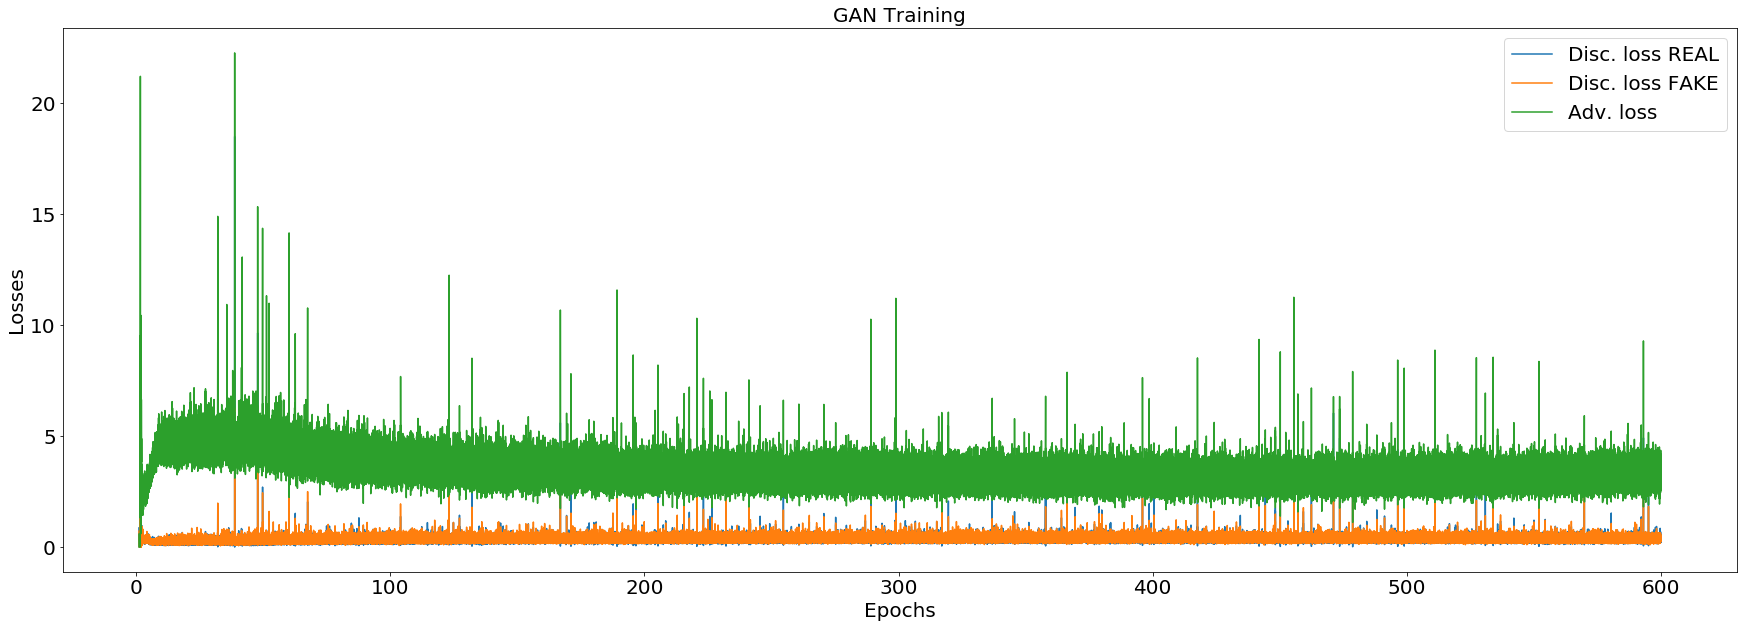

In [29]:
batch_count = tr_seg.shape[0] // batch_size

x_ticks = np.linspace(1,epochs,num=len(d_real_hist))

plt.figure(figsize=(30,10))
plt.plot(x_ticks,d_real_hist, label='Disc. loss REAL')
plt.plot(x_ticks,d_fake_hist, label='Disc. loss FAKE')
plt.plot(x_ticks,a_hist, label='Adv. loss')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Losses', fontsize=20)
plt.legend(loc=1, prop={'size': 20})
plt.tick_params(labelsize=20);
plt.title('GAN Training', fontsize=20)

plt.draw()
plt.savefig('./00_13c_models/training.tiff', bbox_inches='tight',format='tiff')
plt.draw()
plt.savefig('./00_13c_models/training.pdf', bbox_inches='tight',format='pdf')

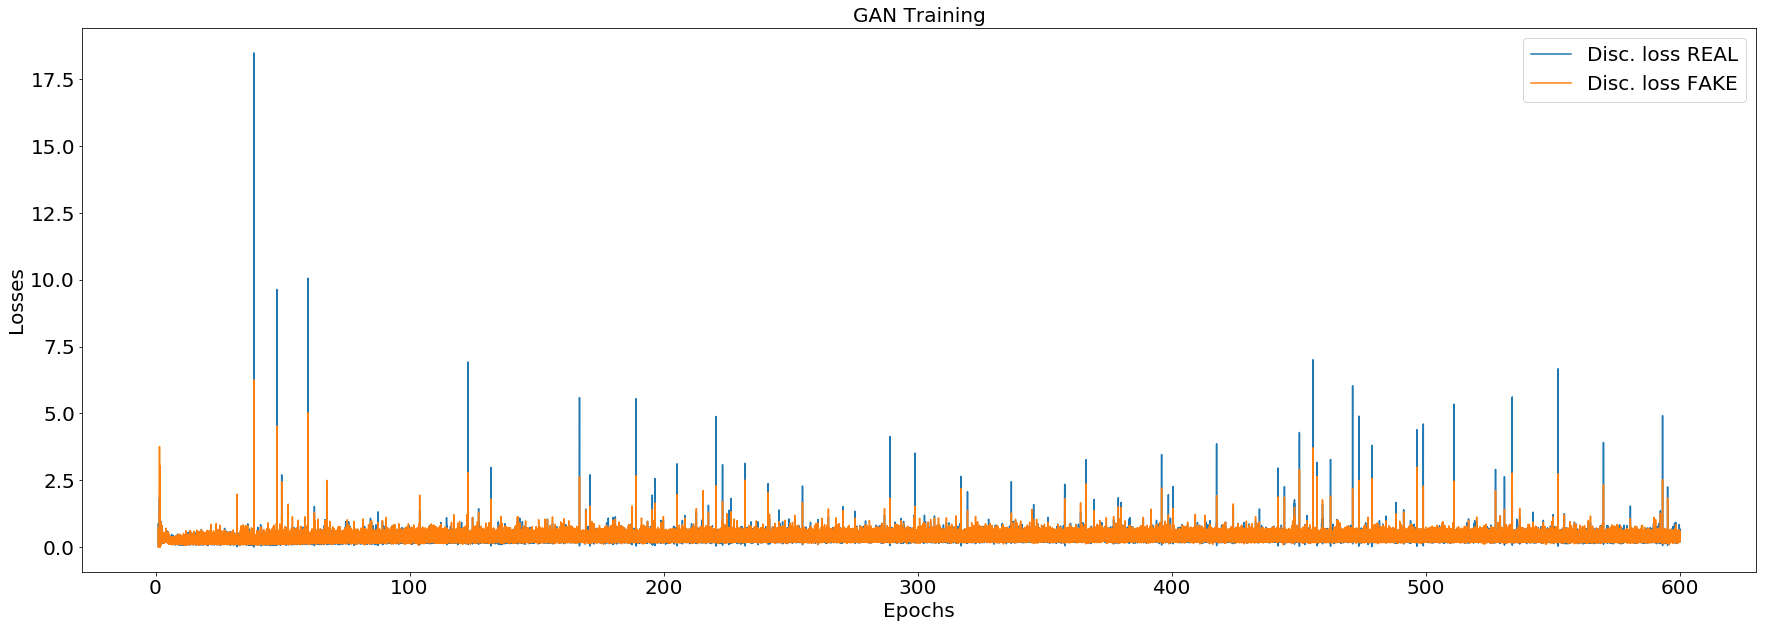

In [30]:
plt.figure(figsize=(30,10))
plt.plot(x_ticks,d_real_hist, label='Disc. loss REAL')
plt.plot(x_ticks,d_fake_hist, label='Disc. loss FAKE')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Losses', fontsize=20)
plt.legend(loc=1, prop={'size': 20})
plt.tick_params(labelsize=20);
plt.title('GAN Training', fontsize=20)

plt.draw()
plt.savefig('./00_13c_models/training_noAdv.tiff', bbox_inches='tight',format='tiff')
plt.draw()
plt.savefig('./00_13c_models/training_noAdv.pdf', bbox_inches='tight',format='pdf')

In [31]:
d_hist = np.asarray(d_real_hist)+np.asarray(d_fake_hist)

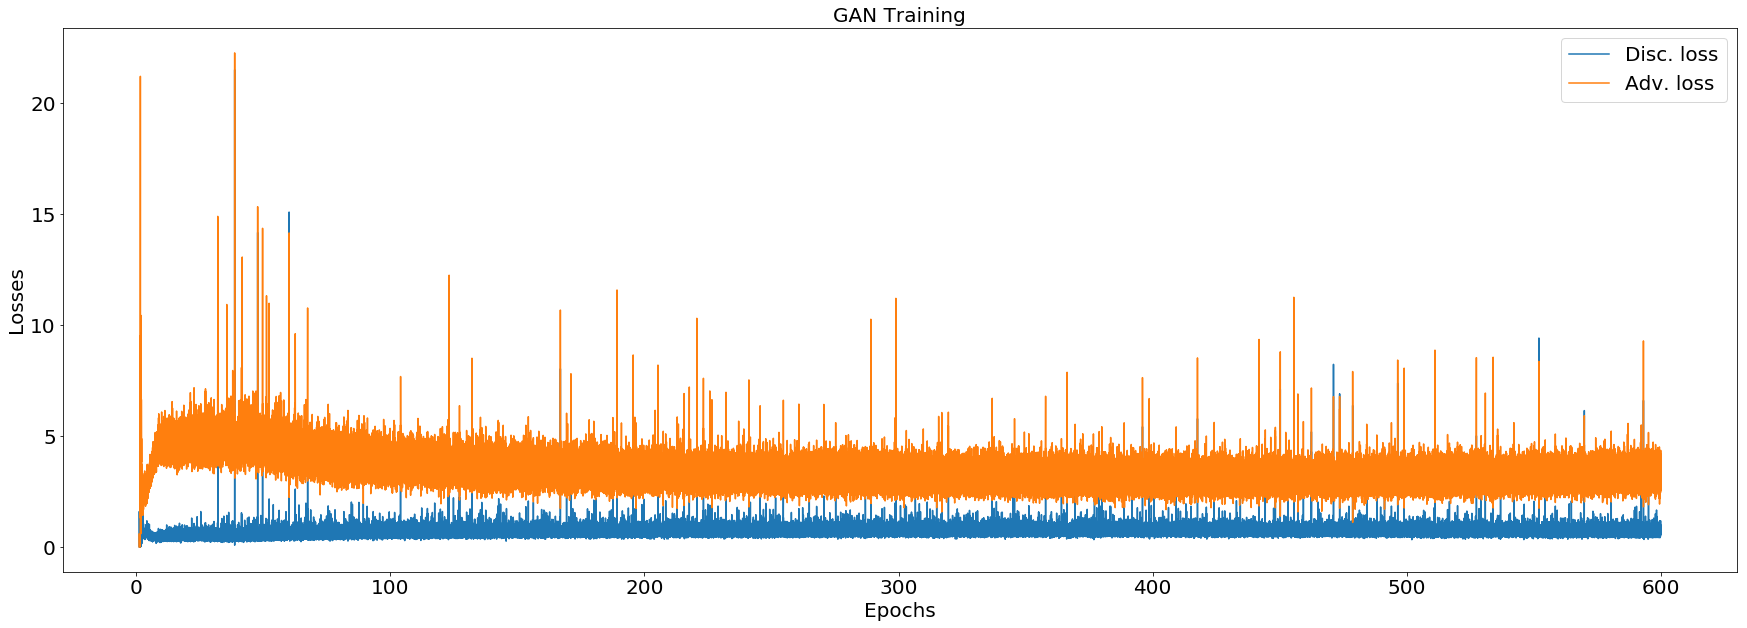

In [32]:
plt.figure(figsize=(30,10))
plt.plot(x_ticks,d_hist, label='Disc. loss')
plt.plot(x_ticks,a_hist, label='Adv. loss')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Losses', fontsize=20)
plt.legend(loc=1, prop={'size': 20})
plt.tick_params(labelsize=20)
plt.title('GAN Training', fontsize=20)

plt.draw()
plt.savefig('./00_13c_models/training2.tiff', bbox_inches='tight',format='tiff')
plt.draw()
plt.savefig('./00_13c_models/training2.pdf', bbox_inches='tight',format='pdf')

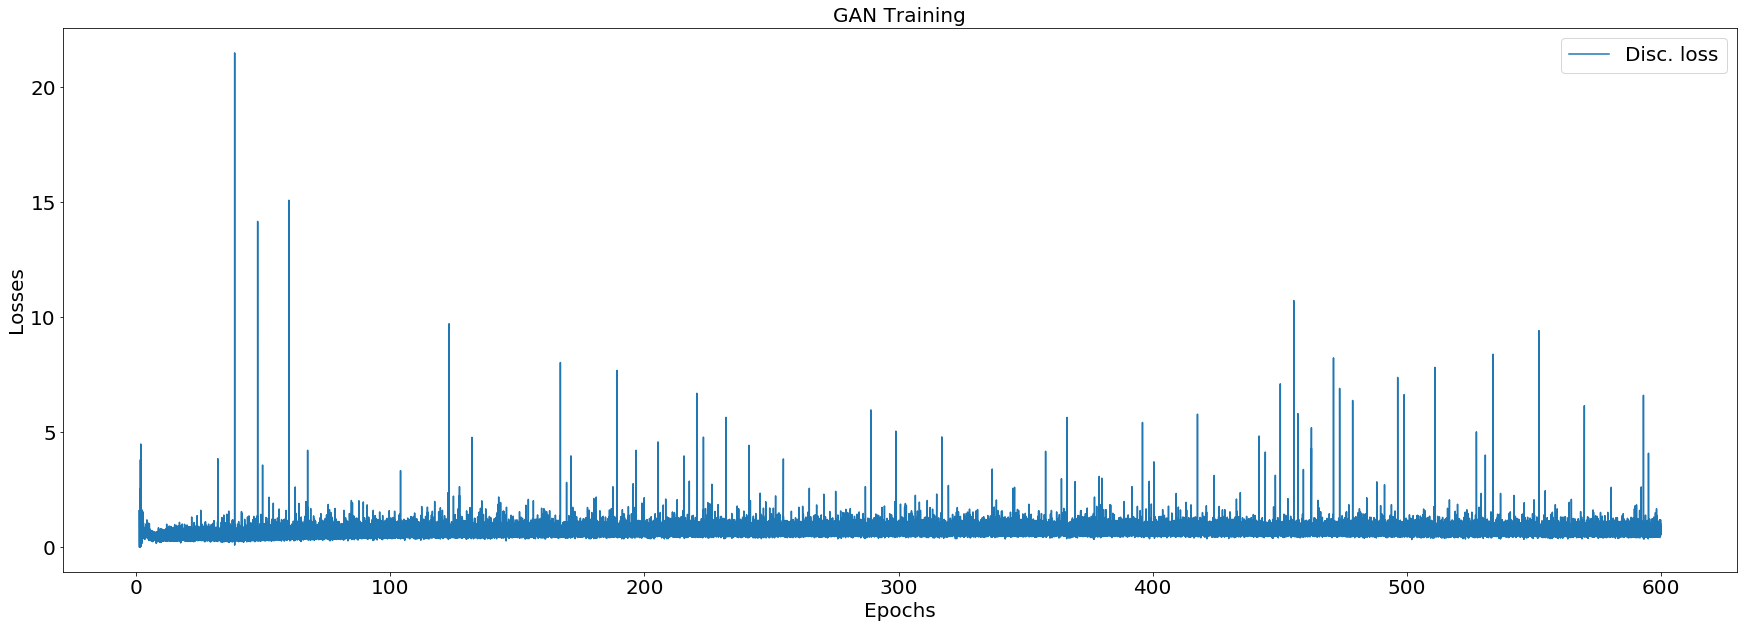

In [33]:
plt.figure(figsize=(30,10))
plt.plot(x_ticks,d_hist, label='Disc. loss')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Losses', fontsize=20)
plt.legend(loc=1, prop={'size': 20})
plt.tick_params(labelsize=20)
plt.title('GAN Training', fontsize=20)

plt.draw()
plt.savefig('./00_13c_models/training2_noAdv.tiff', bbox_inches='tight',format='tiff')
plt.draw()
plt.savefig('./00_13c_models/training2_noAdv.pdf', bbox_inches='tight',format='pdf')

In [34]:
print(d_hist[-1])

0.71567744


In [35]:
print(d_real_hist[-1])
print(d_fake_hist[-1])

0.29528457
0.42039287
